# Monthly Temperature maximum TXX

In [1]:
import intake
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as colors

In [4]:
# Install pyclimdex if not preinstalled.

# !pip install pyclimdex

In [5]:
import climdex.precipitation as pdex # install pyclimdex in previous cell if not installed
import climdex.temperature as tdex 

# Loading dask cluster

In [56]:
from dask.distributed import LocalCluster, Client
cluster = LocalCluster()
client = Client(cluster)
client

/srv/conda/envs/notebook/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39873 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:39873/status,
Dashboard: http://127.0.0.1:39873/status,Workers: 4
Total threads: 4,Total memory: 14.84 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39441,Workers: 4
Dashboard: http://127.0.0.1:39873/status,Total threads: 4
Started: Just now,Total memory: 14.84 GiB
Comm: tcp://127.0.0.1:34761,Total threads: 1
Dashboard: http://127.0.0.1:40535/status,Memory: 3.71 GiB
Nanny: tcp://127.0.0.1:39551,


# climdex Indices

Load the dataset from CESM LENS2 AWS

In [7]:
catalog = intake.open_esm_datastore(
    'https://raw.githubusercontent.com/NCAR/cesm2-le-aws/main/intake-catalogs/aws-cesm2-le.json'
)

catalog = catalog.search(variable=['TREFHTMN', 'TREFHTMX'], frequency='daily')
dsets = catalog.to_dataset_dict(storage_options={"anon":True})
dsets.keys()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency.forcing_variant'


/srv/conda/envs/notebook/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 10.58 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


dict_keys(['atm.ssp370.daily.smbb', 'atm.historical.daily.cmip6', 'atm.ssp370.daily.cmip6', 'atm.historical.daily.smbb'])

Select one ensemble member from the dataset

In [10]:
hist_cmip6 = dsets['atm.historical.daily.cmip6']
hist_cmip6

<xarray.Dataset> Size: 1TB
Dimensions:    (member_id: 50, time: 60225, lat: 192, lon: 288, nbnd: 2)
Coordinates:
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * member_id  (member_id) <U12 2kB 'r10i1181p1f1' ... 'r9i1301p1f1'
  * time       (time) object 482kB 1850-01-01 12:00:00 ... 2014-12-31 12:00:00
    time_bnds  (time, nbnd) object 964kB dask.array<chunksize=(30113, 1), meta=np.ndarray>
Dimensions without coordinates: nbnd
Data variables:
    TREFHTMN   (member_id, time, lat, lon) float32 666GB dask.array<chunksize=(1, 730, 192, 288), meta=np.ndarray>
    TREFHTMX   (member_id, time, lat, lon) float32 666GB dask.array<chunksize=(1, 730, 192, 288), meta=np.ndarray>
Attributes: (12/17)
    Conventions:                       CF-1.0
    logname:                           sunseon
    model_doi_url:                     https://doi.org/10.5065/D67H1H0V
    source:                            CAM
    time_period_freq:                  day_1
    topography_file:                   /mnt/lustre/share/CESM/cesm_input/atm/...
    ...                                ...
    intake_esm_attrs:spatial_domain:   global
    intake_esm_attrs:units:            K
    intake_esm_attrs:start_time:       1850-01-01 12:00:00
    intake_esm_attrs:end_time:         2014-12-31 12:00:00
    intake_esm_attrs:_data_format_:    zarr
    intake_esm_dataset_key:            atm.historical.daily.cmip6

Subset the dataset for a small period.

In [8]:
start_year = 1980
end_year = 2010

# The dataset starts from 1850. So, starting index for 1980 is

start_index = (start_year - 1850)*365
end_index = (end_year - 1850)*365 + 364

start_index, end_index

(47450, 58764)

In [12]:
# Subsets the dataset according for one member and start year to end year
txx_1980_2010 = hist_cmip6['TREFHTMX'][0, start_index:end_index]

In [13]:
tindices = tdex.indices(time_dim='time')
m_txx = tindices.monthly_txx(txx_1980_2010) # calculate monthly txx from first member

<string>:6: FutureWarning: 'M' is deprecated and will be removed in a future version. Please use 'ME' instead of 'M'.


Convert temperature from K to Celsius

In [15]:
m_txx = m_txx - 273.15

In [32]:
hist_cmip6.lat.data, hist_cmip6.lon.data

(array([-90.        , -89.05759162, -88.11518325, -87.17277487,
        -86.23036649, -85.28795812, -84.34554974, -83.40314136,
        -82.46073298, -81.51832461, -80.57591623, -79.63350785,
        -78.69109948, -77.7486911 , -76.80628272, -75.86387435,
        -74.92146597, -73.97905759, -73.03664921, -72.09424084,
        -71.15183246, -70.20942408, -69.26701571, -68.32460733,
        -67.38219895, -66.43979058, -65.4973822 , -64.55497382,
        -63.61256545, -62.67015707, -61.72774869, -60.78534031,
        -59.84293194, -58.90052356, -57.95811518, -57.01570681,
        -56.07329843, -55.13089005, -54.18848168, -53.2460733 ,
        -52.30366492, -51.36125654, -50.41884817, -49.47643979,
        -48.53403141, -47.59162304, -46.64921466, -45.70680628,
        -44.76439791, -43.82198953, -42.87958115, -41.93717277,
        -40.9947644 , -40.05235602, -39.10994764, -38.16753927,
        -37.22513089, -36.28272251, -35.34031414, -34.39790576,
        -33.45549738, -32.51308901, -31.

In [43]:
hist_cmip6.lat.data[138]

40.052356020942405

Creates a longitude latitude coordinate mesh

In [20]:
lon2d, lat2d = np.meshgrid(hist_cmip6.lon.data, hist_cmip6.lat.data)

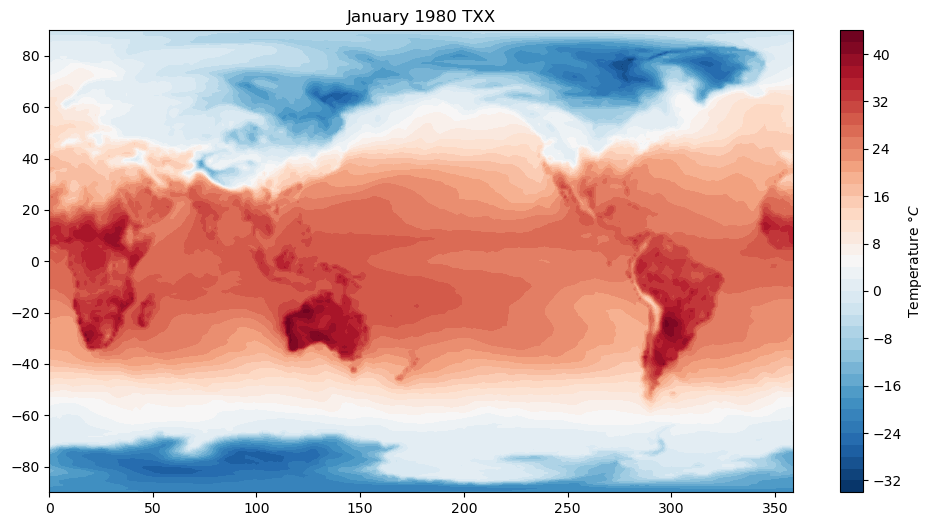

In [30]:
m = 2 # figure size multiplier
f, ax = plt.subplots(1, figsize=(6*m, 3*m))

norm=plt.Normalize(40, -40)
sm = plt.cm.ScalarMappable(cmap="RdBu_r", norm=norm)
im=ax.contourf(lon2d, lat2d, m_txx[0], levels=50, cmap='RdBu_r')
# ax.set_aspect(1)
plt.title('January 1980 TXX')
plt.colorbar(im, ax=ax, label=r'Temperature ${\degree C}$')

We can visualize the temporal trend in monthly maximum temperature for a grid point. 
E.g., Boulder, CO - 40.0150° N, 105.2705° W

In [53]:
grid_point = [40.052356020942405, -105+360]
single_m_txx=m_txx.sel(lat=grid_point[0], lon=grid_point[1])
single_m_txx

<xarray.DataArray 'TREFHTMX' (time: 372)> Size: 1kB
dask.array<getitem, shape=(372,), dtype=float32, chunksize=(24,), chunktype=numpy.ndarray>
Coordinates:
    lat        float64 8B 40.05
    lon        float64 8B 255.0
    member_id  <U12 48B 'r10i1181p1f1'
  * time       (time) object 3kB 1980-01-31 00:00:00 ... 2010-12-31 00:00:00

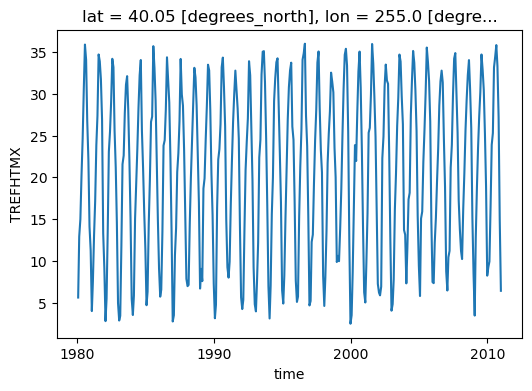

In [58]:
f = plt.figure(figsize=(6,4))
single_m_txx.plot()

In [55]:
client.shutdown()